# Variational Autoencoders for Image Generation
Variational autoencoders (VAEs) are similar to autoencoders in that they encode an input to a lower dimensional space, and then decode it back. The difference is that VAEs encode an input into statistical parameters (mean, variance) to a probability distribution. Points can then be sampled from the distribution and decoded in order to produce a reconstructed image.

In this notebook, I use VAEs trained on MNIST to produce a continuous latent space of handwritten digits.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
tf.compat.v1.disable_eager_execution()

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

First, we'll define the encoder network which maps an input image to two vectors which define a probability distribution over the latent image space: `z_mean` and `z_log_var`.

In [2]:
## VAE ENCODER NETWORK
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = tf.keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

# Encoding Output params
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
## For sampling latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

# Wrapping function as keras layer object
z = layers.Lambda(sampling)([z_mean, z_log_var])

For the decoder scheme, the sampled vector `z` is reshaped into the dimensions of the input image and then passed through convolution layers to obtain an output image. In other words, this will enable the mapping of latent vectors to images.

In [4]:
## VAE DECODER NETWORK
decoder_input = layers.Input(K.int_shape(z)[1:])

#upsampling vector dimensions
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                          padding='same',
                          activation='relu',
                          strides=(2,2))(x)

x = layers.Conv2D(1, 3,
                 padding='same',
                 activation='sigmoid')(x)

decoder = models.Model(decoder_input, x)

z_decoded = decoder(z)

In [5]:
## VAE LOSS FUNCTION
# Custom keras layer
class CustomVariationalLayer(tf.keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

In [6]:
vae = models.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None) #already defined loss in layer
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
## TRAIN VAE
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') /255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(
    x=x_train,
    y=None,
    shuffle=True,
    epochs=10,
    batch_size=batch_size,
    validation_data=(x_test, None)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 37s 611us/sample - loss: 0.2122 - val_loss: 0.1959
Epoch 2/10
60000/60000 [==============================] - 28s 468us/sample - loss: 0.1938 - val_loss: 0.1906
Epoch 3/10
60000/60000 [==============================] - 28s 471us/sample - loss: 0.1901 - val_loss: 0.1897
Epoch 4/10
60000/60000 [==============================] - 28s 468us/sample - loss: 0.1878 - val_loss: 0.1861
Epoch 5/10
60000/60000 [==============================] - 28s 470us/sample - loss: 0.1863 - val_loss: 0.1854
Epoch 6/10
60000/60000 [==============================] - 29s 478us/sample - loss: 0.1849 - val_loss: 0.1838
Epoch 7/10
60000/60000 [==============================] - 28s 469us/sample - loss: 0.1839 - val_loss: 0.1840
Epoch 8/10
60000/60000 [==============================] - 28s 473us/sample - loss: 0.1831 - val_loss: 0.1830
Epoch 9/10
60000/60000 [==============================] - 28s 472us/sample - l

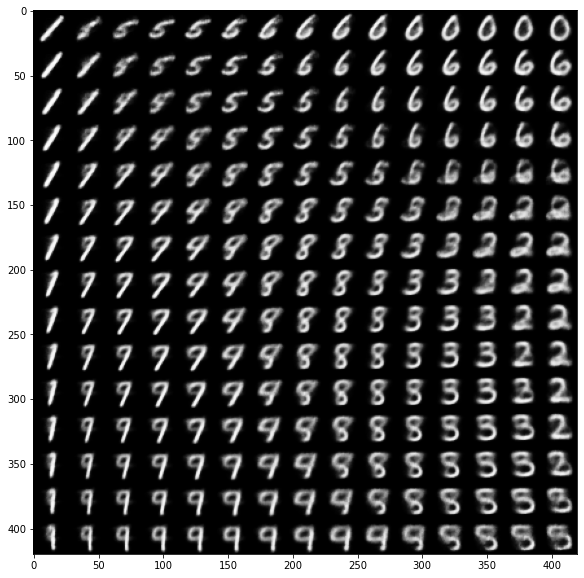

In [8]:
## Sample points from latent space and decode as images

n=15  #grid size to display
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i+1)*digit_size,
               j * digit_size: (j+1)*digit_size] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

The sampled points show a continuous grid of digits gradually changing to a different class when going in a certain direction in the latent space.